# MADE Demo

Autoregressive density estimation for MNIST using masked FFNN (MADE).

In [1]:
import sys
import argparse
import pprint
import pathlib
import numpy as np
import torch
import json
from tqdm import tqdm
from collections import OrderedDict, defaultdict

from torch.distributions import Bernoulli

import dgm
from dgm.conditional import MADEConditioner
from dgm.likelihood import FullyFactorizedLikelihood, AutoregressiveLikelihood
from dgm.opt_utils import get_optimizer, ReduceLROnPlateau
from utils import load_mnist, Batcher



Organise some hyperparameters

In [2]:
from collections import namedtuple

Config = namedtuple(
    "Config", 
    ['seed', 'device', 'batch_size', 'data_dir', 
     'height', 'width', 'input_dropout',
    'hidden_sizes', 'num_masks', 'resample_mask_every', 'll_samples',
    'epochs', 'opt', 'lr', 'momentum', 'l2_weight', 'patience', 'early_stopping'])

args = Config(
    seed=42,
    device='cuda:0',
    batch_size=128,
    data_dir='./data',
    height=28,
    width=28,    
    input_dropout=0.,
    hidden_sizes=[8000, 8000],
    num_masks=1,
    resample_mask_every=20,
    ll_samples=10,
    epochs=200,
    opt='adam',
    lr=1e-4,
    momentum=0.,
    l2_weight=1e-4,
    patience=10,  
    early_stopping=10,    
)

We like reproducibility

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

Load data

In [4]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to='{}/std/{}x{}'.format(args.data_dir, args.height, args.width),
    height=args.height, 
    width=args.width)

Build a model

\begin{align}
    P(x) &= \prod_{i=1}^{|x|} \text{Bern}(x_i|\underbrace{f(x_{<i})}_{\text{MADE}})
\end{align}

For that we need a *conditioner*
* the part that maps prefixes into Bernoulli parameters

and an *autoregressive likelihood*
* the part that combines the Bernoulli factors



In [5]:
x_size = args.width * args.height
device = torch.device(args.device) 
made = MADEConditioner(
    input_size=x_size,  # our only input to the MADE layer is the observation
    output_size=x_size * 1,  # number of parameters to predict
    context_size=0,  # we do not have any additional inputs
    hidden_sizes=args.hidden_sizes,  
    num_masks=args.num_masks
)        
model = AutoregressiveLikelihood(
    event_size=x_size,  # size of observation
    dist_type=Bernoulli, 
    conditioner=made
).to(device)

print("\n# Architecture")
print(model)


# Architecture
AutoregressiveLikelihood(
  (conditioner): MADEConditioner(
    (_made): MADE(
      (hidden_activation): ReLU()
      (net): Sequential(
        (0): MaskedLinear(in_features=784, out_features=8000, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=8000, out_features=8000, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=8000, out_features=784, bias=True)
      )
    )
  )
)


Let's configure the optimiser

In [6]:
print("\n# Optimizer")
opt = get_optimizer(args.opt, model.parameters(), args.lr, args.l2_weight, args.momentum)
scheduler = ReduceLROnPlateau(
    opt, 
    factor=0.5, 
    patience=args.patience,
    early_stopping=args.early_stopping,
    mode='min', threshold_mode='abs')
print(opt)


# Optimizer
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0001
)


Some helper code for batching MNIST digits

In [7]:
def get_batcher(data_loader):
    batcher = Batcher(
        data_loader, 
        height=args.height, 
        width=args.width, 
        device=torch.device(args.device), 
        binarize=True, 
        num_classes=10,
        onehot=True
    )
    return batcher

Helper code for validating a model

In [8]:
def validate(batcher, args, model,
    optimizer=None, scheduler=None, writer=None, name='dev'): 
    """
    :return: stop flag, dict 
        NLL can be found in the dict
    """

    if args.num_masks == 1:
        resample_mask = False
        num_samples = 1
    else:  # ensemble
        resample_mask = True
        num_samples = args.ll_samples    
    
    with torch.no_grad():
        model.eval()
        print_ = defaultdict(list)
        nb_instances = 0.
        for x_mb, y_mb in batcher:
            # [B, H*W]
            x_mb = x_mb.reshape(-1, args.height * args.width)            
            # [B, 10]
            made_inputs = x_mb 
            # [B, H*W]
            p_x = model(
                inputs=None, 
                history=x_mb, 
                num_samples=num_samples, resample_mask=resample_mask
            )
            # [B]            
            nll = -p_x.log_prob(x_mb).sum(-1)
            # accumulate metrics
            print_['NLL'].append(nll.sum().item())
            nb_instances += x_mb.size(0)

        return_dict = {k: np.sum(v) / nb_instances for k, v in print_.items()}
        if writer:            
            writer.add_scalar('%s/NLL' % name, return_dict['NLL'])    

        stop = False
        if scheduler is not None:
            stop = scheduler.step(return_dict['NLL'])
                
        return stop, return_dict  

Main training loop

In [9]:
print("\n# Training")

#from tensorboardX import SummaryWriter        
#writer = SummaryWriter(args.logdir)
writer = None
step = 1

for epoch in range(args.epochs):

    iterator = tqdm(get_batcher(train_loader))

    for x_mb, y_mb in iterator:
        # [B, H*W]
        x_mb = x_mb.reshape(-1, args.height * args.width)
        # [B, 10]
        context = None
        model.train()
        opt.zero_grad()

        if args.num_masks == 1:
            resample_mask = False
        else:  # training with variable masks
            resample_mask = args.resample_mask_every > 0 and step % args.resample_mask_every == 0

        # [B, H*W] 
        noisy_x = torch.where(
            torch.rand_like(x_mb) > args.input_dropout, x_mb, torch.zeros_like(x_mb)
        )
        p_x = model(
            inputs=context,
            history=noisy_x,
            resample_mask=resample_mask
        )
        # [B, H*W]
        ll_mb = p_x.log_prob(x_mb)
        # [B]
        ll = ll_mb.sum(-1)

        loss = -(ll).mean()
        loss.backward()
        opt.step()    


        display = OrderedDict()
        display['0s'] = '{:.2f}'.format((x_mb == 0).float().mean().item())
        display['1s'] = '{:.2f}'.format((x_mb == 1).float().mean().item())
        display['NLL'] =  '{:.2f}'.format(-ll.mean().item())     

        if writer:            
            writer.add_scalar('training/LL', ll)
            #writer.add_image('training/posterior/sample', z.mean(0).reshape(1,1,-1) * 255)

        iterator.set_postfix(display, refresh=False)
        step += 1

    stop, dict_valid = validate(get_batcher(valid_loader), args, model, opt, scheduler, 
        writer=writer, name="dev")

    if stop:
        print('Early stopping at epoch {:3}/{}'.format(epoch + 1, args.epochs))
        break

    print('Epoch {:3}/{} -- '.format(epoch + 1, args.epochs) + \
          ', '.join(['{}: {:4.2f}'.format(k, v) for k, v in sorted(dict_valid.items())]))

  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=540.60]


# Training


  0%|          | 2/430 [00:00<00:27, 15.56it/s, 0s=0.86, 1s=0.14, NLL=186.59]

Epoch   1/200 -- NLL: 178.83


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=146.11]

Epoch   2/200 -- NLL: 146.80


  0%|          | 2/430 [00:00<00:28, 15.00it/s, 0s=0.87, 1s=0.13, NLL=129.89]

Epoch   3/200 -- NLL: 129.88


  0%|          | 2/430 [00:00<00:28, 15.01it/s, 0s=0.87, 1s=0.13, NLL=122.98]

Epoch   4/200 -- NLL: 121.00


  0%|          | 2/430 [00:00<00:28, 14.96it/s, 0s=0.87, 1s=0.13, NLL=111.05]

Epoch   5/200 -- NLL: 115.91


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.88, 1s=0.12, NLL=105.97]

Epoch   6/200 -- NLL: 112.54


  0%|          | 2/430 [00:00<00:28, 14.97it/s, 0s=0.87, 1s=0.13, NLL=108.41]

Epoch   7/200 -- NLL: 110.12


  0%|          | 2/430 [00:00<00:29, 14.51it/s, 0s=0.87, 1s=0.13, NLL=110.41]

Epoch   8/200 -- NLL: 108.26


  0%|          | 2/430 [00:00<00:28, 14.93it/s, 0s=0.86, 1s=0.14, NLL=111.29]

Epoch   9/200 -- NLL: 106.60


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.86, 1s=0.14, NLL=109.08]

Epoch  10/200 -- NLL: 105.41


  0%|          | 2/430 [00:00<00:28, 14.94it/s, 0s=0.87, 1s=0.13, NLL=100.54]

Epoch  11/200 -- NLL: 104.03


  0%|          | 2/430 [00:00<00:28, 14.95it/s, 0s=0.87, 1s=0.13, NLL=101.37]

Epoch  12/200 -- NLL: 102.83


  0%|          | 2/430 [00:00<00:28, 14.99it/s, 0s=0.86, 1s=0.14, NLL=100.94]

Epoch  13/200 -- NLL: 101.76


  0%|          | 2/430 [00:00<00:28, 15.03it/s, 0s=0.87, 1s=0.13, NLL=102.14]

Epoch  14/200 -- NLL: 100.93


  0%|          | 2/430 [00:00<00:28, 14.95it/s, 0s=0.87, 1s=0.13, NLL=96.83]

Epoch  15/200 -- NLL: 100.19


  0%|          | 2/430 [00:00<00:28, 15.01it/s, 0s=0.86, 1s=0.14, NLL=100.46]

Epoch  16/200 -- NLL: 99.53


  0%|          | 2/430 [00:00<00:28, 15.01it/s, 0s=0.87, 1s=0.13, NLL=98.57]

Epoch  17/200 -- NLL: 98.87


  0%|          | 2/430 [00:00<00:28, 14.91it/s, 0s=0.87, 1s=0.13, NLL=95.93]

Epoch  18/200 -- NLL: 98.36


  0%|          | 2/430 [00:00<00:28, 15.00it/s, 0s=0.88, 1s=0.12, NLL=94.52]

Epoch  19/200 -- NLL: 97.65


  0%|          | 2/430 [00:00<00:28, 14.98it/s, 0s=0.88, 1s=0.12, NLL=95.14]

Epoch  20/200 -- NLL: 97.15


  0%|          | 2/430 [00:00<00:28, 15.15it/s, 0s=0.87, 1s=0.13, NLL=95.32]

Epoch  21/200 -- NLL: 96.70


  0%|          | 2/430 [00:00<00:28, 15.01it/s, 0s=0.86, 1s=0.14, NLL=98.83]

Epoch  22/200 -- NLL: 96.50


  0%|          | 2/430 [00:00<00:28, 15.05it/s, 0s=0.87, 1s=0.13, NLL=95.56]

Epoch  23/200 -- NLL: 95.68


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=93.88]

Epoch  24/200 -- NLL: 95.46


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.87, 1s=0.13, NLL=94.70]

Epoch  25/200 -- NLL: 94.99


  0%|          | 2/430 [00:00<00:28, 15.05it/s, 0s=0.87, 1s=0.13, NLL=94.32]

Epoch  26/200 -- NLL: 94.78


  0%|          | 2/430 [00:00<00:28, 15.23it/s, 0s=0.87, 1s=0.13, NLL=92.48]

Epoch  27/200 -- NLL: 94.41


  0%|          | 2/430 [00:00<00:28, 14.95it/s, 0s=0.88, 1s=0.12, NLL=90.83]

Epoch  28/200 -- NLL: 94.17


  0%|          | 2/430 [00:00<00:27, 15.30it/s, 0s=0.87, 1s=0.13, NLL=90.41]

Epoch  29/200 -- NLL: 93.88


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.88, 1s=0.12, NLL=89.75]

Epoch  30/200 -- NLL: 93.69


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=92.13]

Epoch  31/200 -- NLL: 93.05


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.88, 1s=0.12, NLL=90.83]

Epoch  32/200 -- NLL: 93.11


  0%|          | 2/430 [00:00<00:28, 15.09it/s, 0s=0.87, 1s=0.13, NLL=88.42]

Epoch  33/200 -- NLL: 92.71


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.87, 1s=0.13, NLL=87.11]

Epoch  34/200 -- NLL: 92.52


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=88.90]

Epoch  35/200 -- NLL: 92.36


  0%|          | 2/430 [00:00<00:28, 15.14it/s, 0s=0.87, 1s=0.13, NLL=88.92]

Epoch  36/200 -- NLL: 92.06


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.86, 1s=0.14, NLL=90.22]

Epoch  37/200 -- NLL: 91.83


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=89.95]

Epoch  38/200 -- NLL: 91.65


  0%|          | 2/430 [00:00<00:28, 15.14it/s, 0s=0.87, 1s=0.13, NLL=86.14]

Epoch  39/200 -- NLL: 91.48


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=88.80]

Epoch  40/200 -- NLL: 91.10


  0%|          | 2/430 [00:00<00:28, 15.14it/s, 0s=0.87, 1s=0.13, NLL=85.25]

Epoch  41/200 -- NLL: 91.02


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=88.62]

Epoch  42/200 -- NLL: 91.01


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=88.74]

Epoch  43/200 -- NLL: 90.90


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.86, 1s=0.14, NLL=90.56]

Epoch  44/200 -- NLL: 90.64


  0%|          | 2/430 [00:00<00:28, 15.16it/s, 0s=0.87, 1s=0.13, NLL=89.84]

Epoch  45/200 -- NLL: 90.45


  0%|          | 2/430 [00:00<00:28, 15.15it/s, 0s=0.88, 1s=0.12, NLL=85.55]

Epoch  46/200 -- NLL: 90.15


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=86.29]

Epoch  47/200 -- NLL: 90.18


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=88.41]

Epoch  48/200 -- NLL: 89.92


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=89.30]

Epoch  49/200 -- NLL: 89.88


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.87, 1s=0.13, NLL=86.43]

Epoch  50/200 -- NLL: 89.77


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.87, 1s=0.13, NLL=85.85]

Epoch  51/200 -- NLL: 89.75


  0%|          | 2/430 [00:00<00:28, 15.03it/s, 0s=0.87, 1s=0.13, NLL=88.33]

Epoch  52/200 -- NLL: 89.43


  0%|          | 2/430 [00:00<00:28, 15.17it/s, 0s=0.87, 1s=0.13, NLL=87.43]

Epoch  53/200 -- NLL: 89.21


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.87, 1s=0.13, NLL=86.13]

Epoch  54/200 -- NLL: 89.27


  0%|          | 2/430 [00:00<00:28, 15.05it/s, 0s=0.87, 1s=0.13, NLL=87.58]

Epoch  55/200 -- NLL: 88.99


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=87.08]

Epoch  56/200 -- NLL: 88.96


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=89.78]

Epoch  57/200 -- NLL: 88.86


  0%|          | 2/430 [00:00<00:28, 15.29it/s, 0s=0.88, 1s=0.12, NLL=82.58]

Epoch  58/200 -- NLL: 88.77


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=85.00]

Epoch  59/200 -- NLL: 88.69


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=88.11]

Epoch  60/200 -- NLL: 88.38


  0%|          | 2/430 [00:00<00:27, 15.30it/s, 0s=0.87, 1s=0.13, NLL=83.50]

Epoch  61/200 -- NLL: 88.54


  0%|          | 2/430 [00:00<00:28, 15.05it/s, 0s=0.87, 1s=0.13, NLL=88.49]

Epoch  62/200 -- NLL: 88.37


  0%|          | 2/430 [00:00<00:28, 15.17it/s, 0s=0.88, 1s=0.12, NLL=81.83]

Epoch  63/200 -- NLL: 88.52


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.87, 1s=0.13, NLL=85.14]

Epoch  64/200 -- NLL: 88.17


  0%|          | 2/430 [00:00<00:28, 15.21it/s, 0s=0.87, 1s=0.13, NLL=81.86]

Epoch  65/200 -- NLL: 88.04


  0%|          | 2/430 [00:00<00:28, 15.20it/s, 0s=0.87, 1s=0.13, NLL=87.96]

Epoch  66/200 -- NLL: 88.16


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=85.12]

Epoch  67/200 -- NLL: 88.18


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=86.37]

Epoch  68/200 -- NLL: 87.83


  0%|          | 2/430 [00:00<00:28, 15.24it/s, 0s=0.87, 1s=0.13, NLL=85.36]

Epoch  69/200 -- NLL: 87.82


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.86, 1s=0.14, NLL=88.78]

Epoch  70/200 -- NLL: 87.87


  0%|          | 2/430 [00:00<00:28, 15.20it/s, 0s=0.87, 1s=0.13, NLL=84.53]

Epoch  71/200 -- NLL: 87.63


  0%|          | 2/430 [00:00<00:28, 15.04it/s, 0s=0.87, 1s=0.13, NLL=83.23]

Epoch  72/200 -- NLL: 87.63


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=81.23]

Epoch  73/200 -- NLL: 87.57


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.87, 1s=0.13, NLL=82.50]

Epoch  74/200 -- NLL: 87.42


  0%|          | 2/430 [00:00<00:28, 15.15it/s, 0s=0.87, 1s=0.13, NLL=81.42]

Epoch  75/200 -- NLL: 87.41


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.87, 1s=0.13, NLL=82.34]

Epoch  76/200 -- NLL: 87.37


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.87, 1s=0.13, NLL=84.66]

Epoch  77/200 -- NLL: 87.20


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.87, 1s=0.13, NLL=85.22]

Epoch  78/200 -- NLL: 87.29


  0%|          | 2/430 [00:00<00:28, 15.01it/s, 0s=0.88, 1s=0.12, NLL=82.69]

Epoch  79/200 -- NLL: 87.04


  0%|          | 2/430 [00:00<00:28, 15.03it/s, 0s=0.87, 1s=0.13, NLL=86.07]

Epoch  80/200 -- NLL: 87.28


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=84.26]

Epoch  81/200 -- NLL: 87.18


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=82.31]

Epoch  82/200 -- NLL: 87.01


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=84.94]

Epoch  83/200 -- NLL: 86.98


  0%|          | 2/430 [00:00<00:28, 15.15it/s, 0s=0.87, 1s=0.13, NLL=83.31]

Epoch  84/200 -- NLL: 86.97


  0%|          | 2/430 [00:00<00:28, 15.03it/s, 0s=0.86, 1s=0.14, NLL=83.34]

Epoch  85/200 -- NLL: 86.99


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=85.20]

Epoch  86/200 -- NLL: 86.84


  0%|          | 2/430 [00:00<00:28, 15.05it/s, 0s=0.87, 1s=0.13, NLL=81.82]

Epoch  87/200 -- NLL: 86.77


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.87, 1s=0.13, NLL=83.47]

Epoch  88/200 -- NLL: 86.65


  0%|          | 2/430 [00:00<00:28, 15.00it/s, 0s=0.87, 1s=0.13, NLL=80.21]

Epoch  89/200 -- NLL: 86.75


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.86, 1s=0.14, NLL=86.51]

Epoch  90/200 -- NLL: 86.63


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.86, 1s=0.14, NLL=84.78]

Epoch  91/200 -- NLL: 86.57


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.87, 1s=0.13, NLL=84.04]

Epoch  92/200 -- NLL: 86.69


  0%|          | 2/430 [00:00<00:28, 15.23it/s, 0s=0.86, 1s=0.14, NLL=86.96]

Epoch  93/200 -- NLL: 86.53


  0%|          | 2/430 [00:00<00:28, 15.15it/s, 0s=0.87, 1s=0.13, NLL=80.32]

Epoch  94/200 -- NLL: 86.59


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=84.00]

Epoch  95/200 -- NLL: 86.43


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.86, 1s=0.14, NLL=85.80]

Epoch  96/200 -- NLL: 86.21


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.86, 1s=0.14, NLL=84.77]

Epoch  97/200 -- NLL: 86.36


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=82.33]

Epoch  98/200 -- NLL: 86.32


  0%|          | 2/430 [00:00<00:28, 15.25it/s, 0s=0.86, 1s=0.14, NLL=84.73]

Epoch  99/200 -- NLL: 86.29


  0%|          | 2/430 [00:00<00:28, 15.00it/s, 0s=0.87, 1s=0.13, NLL=81.92]

Epoch 100/200 -- NLL: 86.23


  0%|          | 2/430 [00:00<00:28, 15.17it/s, 0s=0.88, 1s=0.12, NLL=82.57]

Epoch 101/200 -- NLL: 86.28


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=81.11]

Epoch 102/200 -- NLL: 86.36


  0%|          | 2/430 [00:00<00:28, 15.02it/s, 0s=0.87, 1s=0.13, NLL=82.56]

Epoch 103/200 -- NLL: 86.35


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.88, 1s=0.12, NLL=81.03]

Epoch 104/200 -- NLL: 86.24


  0%|          | 2/430 [00:00<00:28, 15.16it/s, 0s=0.87, 1s=0.13, NLL=84.81]

Epoch 105/200 -- NLL: 86.06


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.87, 1s=0.13, NLL=83.63]

Epoch 106/200 -- NLL: 86.04


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.87, 1s=0.13, NLL=80.59]

Epoch 107/200 -- NLL: 85.99


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.87, 1s=0.13, NLL=83.43]

Epoch 108/200 -- NLL: 86.03


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.87, 1s=0.13, NLL=80.85]

Epoch 109/200 -- NLL: 85.89


  0%|          | 2/430 [00:00<00:28, 15.09it/s, 0s=0.86, 1s=0.14, NLL=80.67]

Epoch 110/200 -- NLL: 85.90


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.87, 1s=0.13, NLL=82.41]

Epoch 111/200 -- NLL: 85.75


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.87, 1s=0.13, NLL=81.26]

Epoch 112/200 -- NLL: 85.85


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=79.91]

Epoch 113/200 -- NLL: 85.83


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.86, 1s=0.14, NLL=83.63]

Epoch 114/200 -- NLL: 85.73


  0%|          | 2/430 [00:00<00:28, 15.18it/s, 0s=0.87, 1s=0.13, NLL=83.82]

Epoch 115/200 -- NLL: 85.81


  0%|          | 2/430 [00:00<00:28, 15.13it/s, 0s=0.87, 1s=0.13, NLL=83.58]

Epoch 116/200 -- NLL: 85.76


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.86, 1s=0.14, NLL=84.93]

Epoch 117/200 -- NLL: 85.81


  0%|          | 2/430 [00:00<00:28, 15.16it/s, 0s=0.86, 1s=0.14, NLL=82.02]

Epoch 118/200 -- NLL: 85.59


  0%|          | 2/430 [00:00<00:28, 15.08it/s, 0s=0.86, 1s=0.14, NLL=80.44]

Epoch 119/200 -- NLL: 85.61


  0%|          | 2/430 [00:00<00:28, 14.96it/s, 0s=0.87, 1s=0.13, NLL=82.88]

Epoch 120/200 -- NLL: 85.71


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.87, 1s=0.13, NLL=81.17]

Epoch 121/200 -- NLL: 85.68


  0%|          | 2/430 [00:00<00:28, 15.10it/s, 0s=0.87, 1s=0.13, NLL=85.49]

Epoch 122/200 -- NLL: 85.61


  0%|          | 2/430 [00:00<00:28, 15.18it/s, 0s=0.87, 1s=0.13, NLL=83.62]

Epoch 123/200 -- NLL: 85.61


  0%|          | 2/430 [00:00<00:28, 15.15it/s, 0s=0.87, 1s=0.13, NLL=80.56]

Epoch 124/200 -- NLL: 85.57


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=81.25]

Epoch 125/200 -- NLL: 85.65


  0%|          | 2/430 [00:00<00:28, 15.17it/s, 0s=0.87, 1s=0.13, NLL=82.55]

Epoch 126/200 -- NLL: 85.60


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.86, 1s=0.14, NLL=82.18]

Epoch 127/200 -- NLL: 85.47


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=80.45]

Epoch 128/200 -- NLL: 85.69


  0%|          | 2/430 [00:00<00:28, 15.19it/s, 0s=0.87, 1s=0.13, NLL=82.06]

Epoch 129/200 -- NLL: 85.70


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.86, 1s=0.14, NLL=82.71]

Epoch 130/200 -- NLL: 85.51


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.87, 1s=0.13, NLL=80.89]

Epoch 131/200 -- NLL: 85.29


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=77.44]

Epoch 132/200 -- NLL: 85.40


  0%|          | 2/430 [00:00<00:28, 15.07it/s, 0s=0.87, 1s=0.13, NLL=81.14]

Epoch 133/200 -- NLL: 85.57


  0%|          | 2/430 [00:00<00:28, 15.12it/s, 0s=0.87, 1s=0.13, NLL=79.15]

Epoch 134/200 -- NLL: 85.38


  0%|          | 2/430 [00:00<00:28, 15.04it/s, 0s=0.88, 1s=0.12, NLL=80.38]

Epoch 135/200 -- NLL: 85.30


  0%|          | 2/430 [00:00<00:28, 15.14it/s, 0s=0.87, 1s=0.13, NLL=79.21]

Epoch 136/200 -- NLL: 85.32


  0%|          | 2/430 [00:00<00:28, 15.16it/s, 0s=0.87, 1s=0.13, NLL=81.10]

Epoch 137/200 -- NLL: 85.53


  0%|          | 2/430 [00:00<00:28, 15.17it/s, 0s=0.87, 1s=0.13, NLL=81.54]

Epoch 138/200 -- NLL: 85.32


  0%|          | 2/430 [00:00<00:28, 15.06it/s, 0s=0.87, 1s=0.13, NLL=78.96]

Epoch 139/200 -- NLL: 85.56


  0%|          | 2/430 [00:00<00:28, 15.11it/s, 0s=0.87, 1s=0.13, NLL=81.66]

Epoch 140/200 -- NLL: 85.54


100%|██████████| 430/430 [00:28<00:00, 15.42it/s, 0s=0.87, 1s=0.13, NLL=80.93]


Early stopping at epoch 141/200


Let's visualise samples

In [9]:
from matplotlib import pyplot as plt

def visualize_made(batcher: Batcher, args, model, N=4, writer=None, name='dev'): 

    assert N <= args.batch_size, "N should be no bigger than a batch"
    with torch.no_grad():
        model.eval()        
    
        plt.figure(figsize=(2*N, 2*N))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)        
        
        # Some visualisations
        for x_mb, y_mb in batcher:
            
            # [B, H*W]
            x_mb = x_mb.reshape(-1, args.height * args.width)
            x_mb = x_mb[:N]
            # [B, 10]
            context = None
            
            p_x = model(inputs=None, history=x_mb, resample_mask=False)
            # [B, H*W]
            ll = p_x.log_prob(x_mb)
            prob = torch.exp(ll)

            # reconstruct bottom half of N instances
            x_rec = model.sample(inputs=None, history=x_mb, start_from=args.height * args.width // 2)
            # sample N instances
            x_sample = model.sample(
                inputs=None,
                history=torch.zeros(
                    [N, args.height * args.width], 
                    device=torch.device(args.device), 
                    dtype=torch.float32
                ),
                start_from=0
            )
            for i in range(N):
                plt.subplot(4, N, 0*N + i + 1)
                plt.imshow(x_mb[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("x%d" % (i + 1))

                plt.subplot(4, N, 1*N + i + 1)
                plt.imshow(prob[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("prob%d" % (i + 1))
                
                plt.subplot(4, N, 2*N + i + 1)                
                plt.axhline(y=args.height//2, c='red', linewidth=1, ls='--')
                plt.imshow(x_rec[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("rec%d" % (i + 1))
                
                plt.subplot(4, N, 3*N + i + 1)
                plt.imshow(x_sample[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("sample%d" % (i + 1))
                
            break

    plt.show()

A few reconstructions for the validation set as well as samples from the autoregressive likelihood

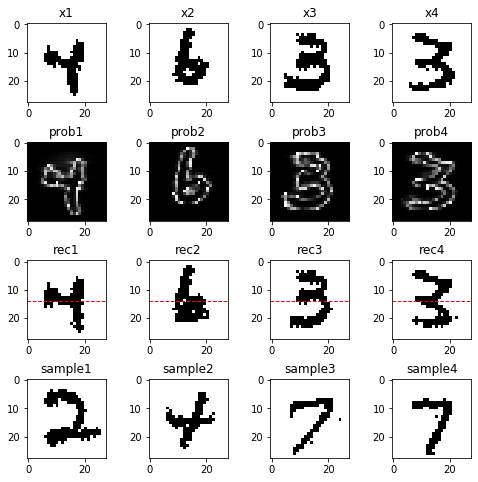

In [11]:
visualize_made(get_batcher(valid_loader), args, model)